In [12]:
google_colab_flag = True

In [13]:
!pip install visualkeras

     |████████████████████████████████| 992 kB 5.1 MB/s 


In [14]:
from google.colab import drive
import sys

In [15]:
if(google_colab_flag):

  drive.mount('/content/drive')
  root_path = '/content/drive/MyDrive/Data/Glaucoma/'
  sys.path.append(root_path)

else:
  root_path = ''

Mounted at /content/drive


In [16]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score 
from sklearn.model_selection import StratifiedKFold
from PIL import Image
from glob import glob
import random
import keras
import tensorflow as tf
from tensorflow import keras
import warnings
import os
import shutil
from PIL import ImageFile

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
import visualkeras

In [17]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2 as cv
import os

In [18]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [19]:
warnings.simplefilter('error', Image.DecompressionBombWarning)
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [20]:
Image.MAX_IMAGE_PIXELS = 1000000000
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [21]:
dataset_folder_name = root_path + 'Dataset'

model_file_name = root_path + 'model_cv.h5'

In [22]:
source_files = []
class_labels = ['glaucoma', 'normal']

X = []
Y = []

In [23]:
image_rows, image_cols = 200, 200

train_path = dataset_folder_name + '/train/'
validation_path = dataset_folder_name + '/validation/'
test_path = dataset_folder_name + '/test/'

In [24]:
def transferBetweenFolders(source, dest, splitRate):

  global source_files
  source_files = os.listdir(source)

  if(len(source_files) != 0):

    transfer_file_numbers = int(len(source_files) * splitRate)
    transfer_index = random.sample(range(0, len(source_files)), transfer_file_numbers)

    for each_index in transfer_index:

      shutil.move(source + str(source_files[each_index]), dest + str(source_files[each_index]))

  else:
    
   print("No file moved. Source empty!") 

In [25]:
def transferAllClassBetweenFolders(source, dest, splitRate):

  for label in class_labels:

    transferBetweenFolders(dataset_folder_name + '/' + source + '/' + label + '/',
                                   dataset_folder_name + '/' + dest + '/' + label + '/',
                                   splitRate)

In [26]:
def my_metrics(y_true, y_pred):

  confusionMatrix = confusion_matrix(y_true, y_pred)
  print(confusionMatrix)

  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred, average= 'weighted')
  sensitivity = confusionMatrix[0, 0] / (confusionMatrix[0,0] + confusionMatrix[0,1])
  specificity = confusionMatrix[1,1]/(confusionMatrix[1,0] + confusionMatrix[1,1])
  f1Score = f1_score(y_true, y_pred, average= 'weighted')


  print("Accuracy  : {}".format(accuracy))
  print("Precision : {}".format(precision))
  print("Sensitivity: {}".format(sensitivity))
  print("specificity: {}".format(specificity))
  print("f1Score : {}".format(f1Score))

  return accuracy, precision, f1Score

In [27]:
transferAllClassBetweenFolders('test', 'train', 1.0)

In [28]:
transferAllClassBetweenFolders('train', 'test', 0.2)

In [29]:
def prepareNameWithLabels(folder_name):

    source_files = os.listdir(dataset_folder_name +'/train/'+ folder_name)
    for val in source_files:
      
        X.append(val)
        for i in range(len(class_labels)):
          if(folder_name == class_labels[i]):
              Y.append(i)

In [30]:
# Organize file names and class labels in X and Y variables

for i in range(len(class_labels)):
  
  prepareNameWithLabels(class_labels[i])

In [31]:
X = np.asarray(X)
Y = np.asarray(Y)

In [32]:
batch_size = 8
epoch = 5

In [33]:
from tensorflow import keras
import keras

In [34]:
model1 = Sequential()

# 1st layers
model1.add(Conv2D(filters= 16, kernel_size= 3, activation= 'relu', input_shape=(image_rows, image_cols, 3)))
model1.add(Conv2D(filters= 16, kernel_size= 3, activation= 'relu'))
model1.add(MaxPool2D(2, 2))

# 2nd layers
model1.add(Conv2D(filters= 32, kernel_size= 3, activation= 'relu'))
model1.add(Conv2D(filters= 32, kernel_size= 3, activation= 'relu'))
model1.add(MaxPool2D(2, 2))

# 3rd layers
model1.add(Conv2D(filters= 64, kernel_size= 3, activation= 'relu'))
model1.add(Conv2D(filters= 64, kernel_size= 3, activation= 'relu'))
model1.add(MaxPool2D(2, 2))

model1.add(Flatten())

model1.add(Dense(512, activation= 'relu'))
model1.add(Dense(len(class_labels), activation= 'sigmoid'))

In [35]:
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [36]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 196, 196, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 98, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 94, 94, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                    

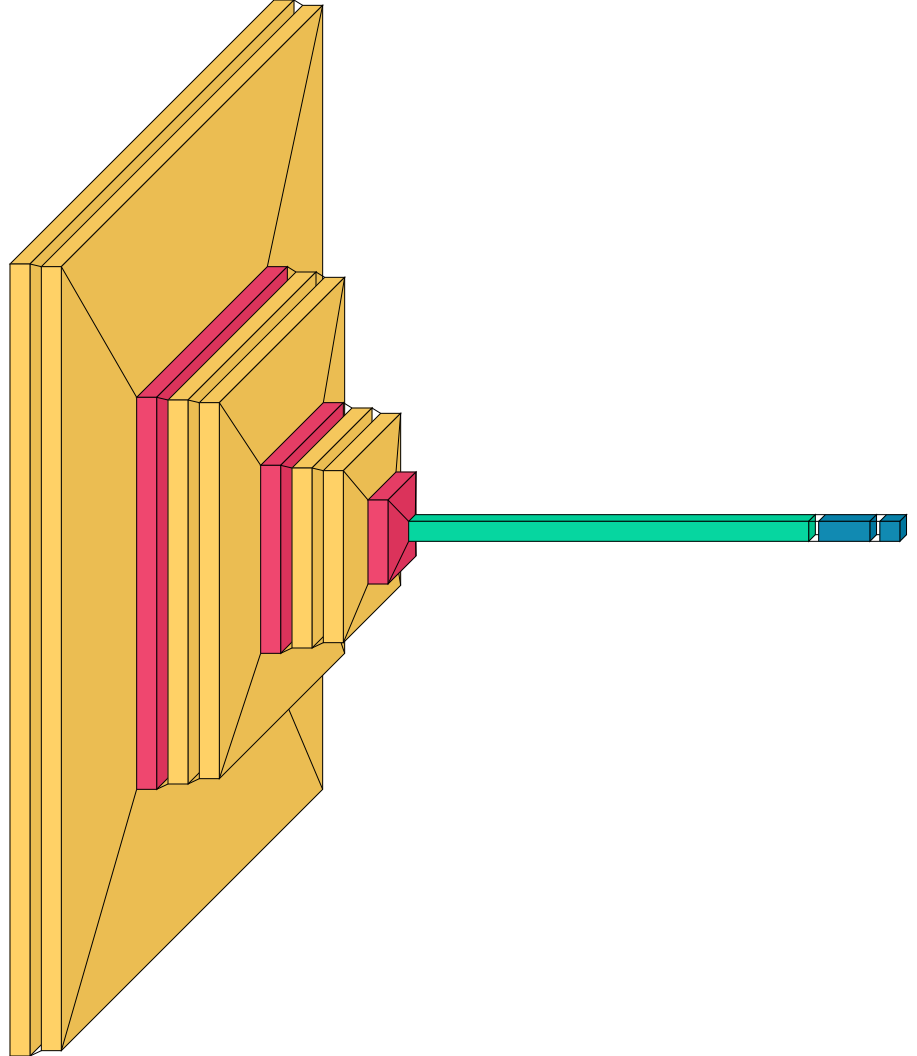

In [37]:
visualkeras.layered_view(model1)

In [38]:
skf = StratifiedKFold(n_splits = 5, shuffle=True)
skf.get_n_splits(X, Y)

foldNum=0

In [39]:
for train_index, val_index in skf.split(X, Y):

  transferAllClassBetweenFolders('validation', 'train', 1.0)

  foldNum += 1
  print("Fold Result: ", foldNum)

  X_train, X_val = X[train_index], X[val_index]
  Y_train, Y_val = Y[train_index], Y[val_index]

  for each_index in range(len(X_val)):

    class_label = ''
    for i in range(len(class_labels)):

      if(Y_val[each_index] == i):
        class_label = class_labels[i]

    shutil.move(dataset_folder_name + '/train/' + class_label + '/' + X_val[each_index],
                dataset_folder_name + '/validation/' + class_label + '/' + X_val[each_index])
  
  train_datagen = ImageDataGenerator(
                      rescale = 1./255,
                      zoom_range = 0.20,
                      fill_mode = "nearest")
  
  validation_datagen = ImageDataGenerator(rescale = 1./255)

  test_datagen = ImageDataGenerator(rescale = 1./255)

  #Start ImageClassification Model
  train_generator = train_datagen.flow_from_directory(
      
      train_path,
      target_size = (image_rows, image_cols),
      batch_size = batch_size,
      class_mode = 'categorical',
      subset = 'training')

  validation_generator = validation_datagen.flow_from_directory(
      
      validation_path,
      target_size = (image_rows, image_cols),
      batch_size = batch_size,
      class_mode = None,  # only data, no labels
      shuffle = False)
  
  # fit model

  history = model1.fit_generator(train_generator, 
                        epochs = epoch
                        )
    
  predictions = model1.predict_generator(validation_generator, verbose=1)
  yPredictions = np.argmax(predictions, axis=1)
  true_classes = validation_generator.classes

  # evaluate validation performance

  print("***Performance on Validation data***")    
  valAcc, valPrec, valFScore = my_metrics(true_classes, yPredictions)

Fold Result:  1
Found 271 images belonging to 2 classes.
Found 57 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/5
34/34 [==============================] - 53s 1s/step - loss: 0.3133 - accuracy: 0.8672
Epoch 2/5
34/34 [==============================] - 43s 1s/step - loss: 0.2248 - accuracy: 0.8893
Epoch 3/5
34/34 [==============================] - 42s 1s/step - loss: 0.2223 - accuracy: 0.8893
Epoch 4/5
34/34 [==============================] - 42s 1s/step - loss: 0.2076 - accuracy: 0.9041
Epoch 5/5
34/34 [==============================] - 42s 1s/step - loss: 0.2172 - accuracy: 0.9151


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


8/8 [==============================] - 28s 4s/step
***Performance on Validation data***
[[51  0]
 [ 5  1]]
Accuracy  : 0.9122807017543859
Precision : 0.9201127819548872
Sensitivity: 1.0
specificity: 0.16666666666666666
f1Score : 0.8830018972665308
Fold Result:  2
Found 271 images belonging to 2 classes.
Found 57 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/5
34/34 [==============================] - 43s 1s/step - loss: 0.1389 - accuracy: 0.9410
Epoch 2/5
34/34 [==============================] - 43s 1s/step - loss: 0.2106 - accuracy: 0.9262
Epoch 3/5
34/34 [==============================] - 48s 1s/step - loss: 0.1621 - accuracy: 0.9483
Epoch 4/5
34/34 [==============================] - 43s 1s/step - loss: 0.2071 - accuracy: 0.9225
Epoch 5/5
34/34 [==============================] - 48s 1s/step - loss: 0.2052 - accuracy: 0.9410


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


8/8 [==============================] - 5s 560ms/step
***Performance on Validation data***
[[50  0]
 [ 3  4]]
Accuracy  : 0.9473684210526315
Precision : 0.9503475670307845
Sensitivity: 1.0
specificity: 0.5714285714285714
f1Score : 0.9409578668648675
Fold Result:  3
Found 272 images belonging to 2 classes.
Found 56 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/5
34/34 [==============================] - 44s 1s/step - loss: 0.1526 - accuracy: 0.9559
Epoch 2/5
34/34 [==============================] - 43s 1s/step - loss: 0.0989 - accuracy: 0.9559
Epoch 3/5
34/34 [==============================] - 43s 1s/step - loss: 0.1071 - accuracy: 0.9706
Epoch 4/5
34/34 [==============================] - 55s 2s/step - loss: 0.1637 - accuracy: 0.9559
Epoch 5/5
34/34 [==============================] - 45s 1s/step - loss: 0.0599 - accuracy: 0.9779


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


7/7 [==============================] - 5s 635ms/step
***Performance on Validation data***
[[50  0]
 [ 1  5]]
Accuracy  : 0.9821428571428571
Precision : 0.9824929971988795
Sensitivity: 1.0
specificity: 0.8333333333333334
f1Score : 0.9814195705284813
Fold Result:  4
Found 272 images belonging to 2 classes.
Found 56 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/5
34/34 [==============================] - 44s 1s/step - loss: 0.0439 - accuracy: 0.9853
Epoch 2/5
34/34 [==============================] - 43s 1s/step - loss: 0.1892 - accuracy: 0.9559
Epoch 3/5
34/34 [==============================] - 44s 1s/step - loss: 0.1827 - accuracy: 0.9375
Epoch 4/5
34/34 [==============================] - 43s 1s/step - loss: 0.1679 - accuracy: 0.9375
Epoch 5/5
34/34 [==============================] - 44s 1s/step - loss: 0.0541 - accuracy: 0.9816


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


7/7 [==============================] - 5s 630ms/step
***Performance on Validation data***
[[50  0]
 [ 2  4]]
Accuracy  : 0.9642857142857143
Precision : 0.9656593406593407
Sensitivity: 1.0
specificity: 0.6666666666666666
f1Score : 0.961064425770308
Fold Result:  5
Found 272 images belonging to 2 classes.
Found 56 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/5
34/34 [==============================] - 43s 1s/step - loss: 0.0693 - accuracy: 0.9779
Epoch 2/5
34/34 [==============================] - 44s 1s/step - loss: 0.0532 - accuracy: 0.9743
Epoch 3/5
34/34 [==============================] - 43s 1s/step - loss: 0.0628 - accuracy: 0.9816
Epoch 4/5
34/34 [==============================] - 43s 1s/step - loss: 0.0817 - accuracy: 0.9706
Epoch 5/5
34/34 [==============================] - 44s 1s/step - loss: 0.0365 - accuracy: 0.9926


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


7/7 [==============================] - 4s 617ms/step
***Performance on Validation data***
[[50  0]
 [ 1  5]]
Accuracy  : 0.9821428571428571
Precision : 0.9824929971988795
Sensitivity: 1.0
specificity: 0.8333333333333334
f1Score : 0.9814195705284813


In [49]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

In [50]:
train_datagen = ImageDataGenerator(
                      rescale = 1./255,
                      zoom_range = 0.20,
                      fill_mode = "nearest")
  
validation_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

#Start ImageClassification Model
train_generator = train_datagen.flow_from_directory(
      
    train_path,
    target_size = (image_rows, image_cols),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training')

validation_generator = validation_datagen.flow_from_directory(
      
    validation_path,
    target_size = (image_rows, image_cols),
    batch_size = batch_size,
    class_mode = None,  # only data, no labels
    shuffle = False)

Found 272 images belonging to 2 classes.
Found 56 images belonging to 2 classes.


In [57]:
print('=============== Test Result ==============')

test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size = (image_rows, image_cols),
                                                  batch_size = batch_size,
                                                  class_mode = None,
                                                  shuffle = False)

predictions = model1.predict(test_generator, verbose = 1)
yPredictions = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

testAcc,testPrec, testFScore = my_metrics(true_classes, yPredictions)
model1.save(model_file_name)

=============== Test Result ==============
Found 69 images belonging to 2 classes.
9/9 [==============================] - 33s 4s/step
[[62  0]
 [ 1  6]]
Accuracy  : 0.9855072463768116
Precision : 0.9857372900851161
Sensitivity: 1.0
specificity: 0.8571428571428571
f1Score : 0.9850078037904124


In [66]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [67]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [68]:
# predict probabilities
pred_prob1 = model1.predict(test_generator)

In [69]:
from sklearn.metrics import roc_curve

In [70]:
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(yPredictions, pred_prob1[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(yPredictions))]
p_fpr, p_tpr, _ = roc_curve(yPredictions, random_probs, pos_label=1)

In [71]:
from sklearn.metrics import roc_auc_score

# auc scores
auc_score1 = roc_auc_score(yPredictions, pred_prob1[:,1])

print("Area Under Curve: ", auc_score1)

Area Under Curve:  1.0


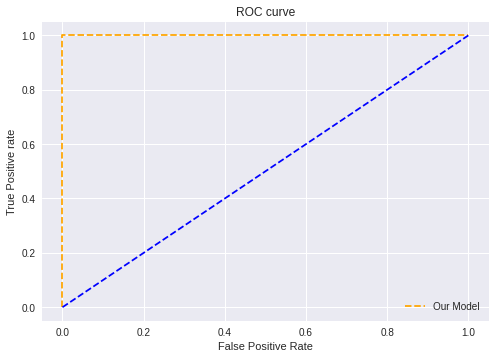

In [72]:
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Our Model')
#plt.plot(fpr2, tpr2, linestyle='--',color='green', label='VGG16')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();